In [1]:
# IMPORTO LIBRERIE

import numpy as np
import matplotlib.pyplot as plt
from qutip import *

In [ ]:
def MHQ_3level_vecchia(stato, hamiltoniano, c_ops, O_1, O_2, t_list, args = None, iniziali = False):
    """Restituisce le MHQ, probabilità congiunte TPM e probabilità esiti finali
    (per verifica marginalizzazione) per sistemi a tre livelli"""
    Q = np.zeros((3,3))
    TPM = np.zeros((3,3))

    # Determino proiettori necessari per O_1
    _, autovettori_1 = O_1.eigenstates()
    o_11, o_12, o_13 = autovettori_1
    proiettore_11 = o_11 * o_11.dag()
    proiettore_12 = o_12 * o_12.dag()
    proiettore_13 = o_13 * o_13.dag()

    # Determino proiettori necessari per O_2
    _, autovettori_2 = O_2.eigenstates()
    o_21, o_22, o_23 = autovettori_2    # Ordinati in maniera crescente degli autovalori
    proiettore_21 = o_21 * o_21.dag()
    proiettore_22 = o_22 * o_22.dag()
    proiettore_23 = o_23 * o_23.dag()

    # Grafici
    probabilita_iniziali = []

    # Schema TPM
    
    # Caso 1: misuro o_11
    rho_1 = (proiettore_11 * stato * proiettore_11).unit()
    prob_1 = np.real_if_close((proiettore_11 * stato).tr())
    probabilita_iniziali.append(prob_1)

    evoluto_1 = mesolve(hamiltoniano, rho_1, t_list, c_ops=c_ops, args=args)
    
    p_1_1 = np.real_if_close((proiettore_21 * evoluto_1.states[-1]).tr()) * prob_1 
    p_1_2 = np.real_if_close((proiettore_22 * evoluto_1.states[-1]).tr()) * prob_1
    p_1_3 = np.real_if_close((proiettore_23 * evoluto_1.states[-1]).tr()) * prob_1
    
    TPM[0, 0] = p_1_1
    TPM[0, 1] = p_1_2
    TPM[0, 2] = p_1_3

    # Caso 2: misuro o_12
    rho_2 = (proiettore_12 * stato * proiettore_12).unit()
    prob_2 = np.real_if_close((proiettore_12 * stato).tr())
    probabilita_iniziali.append(prob_2)

    evoluto_2 = mesolve(hamiltoniano, rho_2, t_list, c_ops=c_ops, args=args)
    
    p_2_1 = np.real_if_close((proiettore_21 * evoluto_2.states[-1]).tr()) * prob_2
    p_2_2 = np.real_if_close((proiettore_22 * evoluto_2.states[-1]).tr()) * prob_2
    p_2_3 = np.real_if_close((proiettore_23 * evoluto_2.states[-1]).tr()) * prob_2
    
    TPM[1, 0] = p_2_1
    TPM[1, 1] = p_2_2
    TPM[1, 2] = p_2_3

    # Caso 3: misuro o_13
    rho_3 = (proiettore_13 * stato * proiettore_13).unit()
    prob_3 = np.real_if_close((proiettore_13 * stato).tr())
    probabilita_iniziali.append(prob_3)

    evoluto_3 = mesolve(hamiltoniano, rho_3, t_list, c_ops=c_ops, args=args)
    
    p_3_1 = np.real_if_close((proiettore_21 * evoluto_3.states[-1]).tr()) * prob_3
    p_3_2 = np.real_if_close((proiettore_22 * evoluto_3.states[-1]).tr()) * prob_3
    p_3_3 = np.real_if_close((proiettore_23 * evoluto_3.states[-1]).tr()) * prob_3
    
    TPM[2, 0] = p_3_1
    TPM[2, 1] = p_3_2
    TPM[2, 2] = p_3_3

    # Post selezione (evoluzione senza misura iniziale)
    evoluto = mesolve(hamiltoniano, stato, t_list, c_ops=c_ops, args=args)

    pf_1 = np.real_if_close((proiettore_21 * evoluto.states[-1]).tr())
    pf_2 = np.real_if_close((proiettore_22 * evoluto.states[-1]).tr())
    pf_3 = np.real_if_close((proiettore_23 * evoluto.states[-1]).tr())

    # Misura non selettiva
    # Su O_1
    rho_ns = (proiettore_11 * stato * proiettore_11 + (qeye(3) - proiettore_11) * stato * (qeye(3) - proiettore_11)).unit()  # Stato dopo misura non selettiva
               
    evoluto_ns = mesolve(hamiltoniano, rho_ns, t_list, c_ops=c_ops, args=args)
    
    w_1_1 = np.real_if_close((proiettore_21 * evoluto_ns.states[-1]).tr())
    w_1_2 = np.real_if_close((proiettore_22 * evoluto_ns.states[-1]).tr())
    w_1_3 = np.real_if_close((proiettore_23 * evoluto_ns.states[-1]).tr())


    # Su O_2
    rho_ns = (proiettore_12 * stato * proiettore_12 + (qeye(3) - proiettore_12) * stato * (qeye(3) - proiettore_12)).unit()  # Stato dopo misura non selettiva
    evoluto_ns = mesolve(hamiltoniano, rho_ns, t_list, c_ops=c_ops, args=args)

    w_2_1 = np.real_if_close((proiettore_21 * evoluto_ns.states[-1]).tr())
    w_2_2 = np.real_if_close((proiettore_22 * evoluto_ns.states[-1]).tr())
    w_2_3 = np.real_if_close((proiettore_23 * evoluto_ns.states[-1]).tr())

    # Su O_3
    rho_ns = (proiettore_13 * stato * proiettore_13 + (qeye(3) - proiettore_13) * stato * (qeye(3) - proiettore_13)).unit()  # Stato dopo misura non selettiva

    evoluto_ns = mesolve(hamiltoniano, rho_ns, t_list, c_ops=c_ops, args=args)

    w_3_1 = np.real_if_close((proiettore_21 * evoluto_ns.states[-1]).tr())
    w_3_2 = np.real_if_close((proiettore_22 * evoluto_ns.states[-1]).tr())
    w_3_3 = np.real_if_close((proiettore_23 * evoluto_ns.states[-1]).tr())

    # Calcolo delle quasiprobabilità di Kirkwood-Dirac
    # Prima colonna (outcome finale 1)
    Q[0, 0] = p_1_1 + 0.5 * (pf_1 - w_1_1)
    Q[1, 0] = p_2_1 + 0.5 * (pf_1 - w_2_1)
    Q[2, 0] = p_3_1 + 0.5 * (pf_1 - w_3_1)
    
    # Seconda colonna (outcome finale 2)
    Q[0, 1] = p_1_2 + 0.5 * (pf_2 - w_1_2)
    Q[1, 1] = p_2_2 + 0.5 * (pf_2 - w_2_2)
    Q[2, 1] = p_3_2 + 0.5 * (pf_2 - w_3_2)
    
    # Terza colonna (outcome finale 3)
    Q[0, 2] = p_1_3 + 0.5 * (pf_3 - w_1_3)
    Q[1, 2] = p_2_3 + 0.5 * (pf_3 - w_2_3)
    Q[2, 2] = p_3_3 + 0.5 * (pf_3 - w_3_3)

    if iniziali:
        return Q, TPM, probabilita_iniziali

    return Q, TPM, [pf_1, pf_2, pf_3]

In [34]:
def MHQ_3level(stato, hamiltoniano, c_ops, O_1, O_2, t_list, args=None, iniziali=False):
    """
    Calcola le quasiprobabilità di Kirkwood-Dirac (MHQ), la matrice TPM 
    e le probabilità finali o iniziali, per un sistema a 3 livelli.
    """
    Q = np.zeros((3, 3), dtype=np.complex128)
    TPM = np.zeros((3, 3), dtype=np.float64)
    prob_iniziali = []

    # Proiettori autostati iniziali e finali
    _, eigvecs_1 = O_1.eigenstates()
    projs_1 = [v * v.dag() for v in eigvecs_1]
    
    _, eigvecs_2 = O_2.eigenstates()
    projs_2 = [v * v.dag() for v in eigvecs_2]

    # Misura iniziale selettiva
    rho_f = mesolve(hamiltoniano, stato, t_list, c_ops=c_ops, args=args).states[-1]
    pf = [np.real_if_close((P * rho_f).tr()) for P in projs_2]

    p_ij = np.zeros((3, 3), dtype=np.float64)
    w_ij = np.zeros((3, 3), dtype=np.float64)

    for i, Pi in enumerate(projs_1):
        prob_i = np.real_if_close((Pi * stato).tr())
        prob_iniziali.append(prob_i)
        rho_i = (Pi * stato * Pi).unit()
        rho_i_evol = mesolve(hamiltoniano, rho_i, t_list, c_ops=c_ops, args=args).states[-1]
        for j, Pj in enumerate(projs_2):
            p_ij[i, j] = np.real_if_close((Pj * rho_i_evol).tr()) * prob_i
            TPM[i, j] = p_ij[i, j]

        # Misura non selettiva su O1 (per ogni proiettore)
        Pi_comp = (qeye(3) - Pi)
        rho_ns = (Pi * stato * Pi + Pi_comp * stato * Pi_comp).unit()
        rho_ns_evol = mesolve(hamiltoniano, rho_ns, t_list, c_ops=c_ops, args=args).states[-1]
        for j, Pj in enumerate(projs_2):
            w_ij[i, j] = np.real_if_close((Pj * rho_ns_evol).tr())

    # Costruzione delle MHQ (Kirkwood-Dirac)
    for i in range(3):
        for j in range(3):
            Q[i, j] = p_ij[i, j] + 0.5 * (pf[j] - w_ij[i, j])

    if iniziali:
        return Q, TPM, prob_iniziali
    return Q, TPM, pf

In [4]:
def plot_MHQ_3level(Q, TPM, autovalori_1, autovalori_2):
    """Visualizza la MHQ e la TPM per un sistema a 3 livelli."""
    fig, ax = plt.subplots(1, 2, figsize=(13, 6))

    # Etichette
    labels_f = [f'{v:.3f}' for v in autovalori_2]
    labels_i = [f'{v:.3f}' for v in autovalori_1]

    # MHQ plot
    cax1 = ax[0].matshow(Q.real, cmap='RdBu_r', vmin=-1, vmax=1)
    fig.colorbar(cax1, ax=ax[0])
    ax[0].set_title('MHQ (wTPM)')
    ax[0].set_xlabel('Hamiltoniano finale')
    ax[0].set_ylabel('Hamiltoniano iniziale')
    ax[0].set_xticks(range(3))
    ax[0].set_yticks(range(3))
    ax[0].set_xticklabels(labels_f)
    ax[0].set_yticklabels(labels_i)

    for (i, j), val in np.ndenumerate(Q.real):
        ax[0].text(j, i, f'{val:.3f}', ha='center', va='center',
                   color='white' if abs(val) > 0.5 else 'black')

    # TPM plot
    cax2 = ax[1].matshow(TPM, cmap='RdBu_r', vmin=-1, vmax=1)
    fig.colorbar(cax2, ax=ax[1])
    ax[1].set_title('Probabilità (TPM)')
    ax[1].set_xlabel('Hamiltoniano finale')
    ax[1].set_ylabel('Hamiltoniano iniziale')
    ax[1].set_xticks(range(3))
    ax[1].set_yticks(range(3))
    ax[1].set_xticklabels(labels_f)
    ax[1].set_yticklabels(labels_i)

    for (i, j), val in np.ndenumerate(TPM):
        ax[1].text(j, i, f'{val:.3f}', ha='center', va='center',
                   color='black')

    plt.tight_layout()
    plt.show()


In [27]:
# ————————————————————————————————
# 1) Definizioni di base secondo Eq. (16)
# ————————————————————————————————
hbar = 1.0
D       = 2.87      # zero‐field splitting [GHz]
gamma_e = 28.0      # gyromagnetic ratio [GHz/T]
B       = 0.01      # campo esterno [T]

# Base del qutrit |+1>, |0>, |-1>
e_plus  = basis(3, 0)
e_zero  = basis(3, 1)
e_minus = basis(3, 2)

# Hamiltoniana NV
Sz = Qobj(np.diag([+1, 0, -1]))
H_NV = D * Sz**2 + gamma_e * B * Sz

# ————————————————————————————————
# 2) Hamiltoniana nel sdr del laboratorio, Eq. (17)
# ——————————————————————————————————————————————————————————
# frequenze di Bohr
omega_p = D + gamma_e * B    # |0> <--> |+1>
omega_m = D - gamma_e * B    # |0> <--> |-1>

# operatori di transizione
P_p0 = e_plus  * e_zero.dag()  + e_zero * e_plus.dag()  # |+1> <--> |0>
P_m0 = e_minus * e_zero.dag()  + e_zero * e_minus.dag() # |-1> <--> |0>

# Rabi frequencies
Omega1 = 2.219 * 2*np.pi  * 10**(-3)         # MHz 
Omega2 = Omega1                               

def H_drive_lab(t, args):
    phi1, phi2 = args.get('phi1',0), args.get('phi2',0)  # da dizionario le fasi oppure setto a zero
    H1 = Omega1 * np.cos(omega_p * t + phi1) * P_p0
    H2 = Omega2 * np.cos(omega_m * t + phi2) * P_m0
    return H1 + H2

# lista per qutip
H_lab = [
    H_NV,   # parte stazionaria
    [P_p0, lambda t, args: hbar*Omega1 * np.cos(omega_p * t + args.get('phi1',0)*t)],
    [P_m0, lambda t, args: hbar*Omega2 * np.cos(omega_m * t + args.get('phi2',0)*t)]
]

# ————————————————————————————————
# 3) Hamiltoniana nel rotating frame, Eq. (18)
# ——————————————————————————————————————————————
# Matrici di Gell-Mann
lambda1 = Qobj([[0,1,0],[1,0,0],[0,0,0]])
lambda2 = Qobj([[0,-1j,0],[1j,0,0],[0,0,0]])
lambda6 = Qobj([[0,0,0],[0,0,1],[0,1,0]])
lambda7 = Qobj([[0,0,0],[0,0,-1j],[0,1j,0]])

Sx1 = lambda1/np.sqrt(2)
Sy1 = lambda2/np.sqrt(2)
Sx2 = lambda6/np.sqrt(2)
Sy2 = lambda7/np.sqrt(2)

def H_rot(t, args = {'phi1': 1.09*Omega1, 'phi2': 1.09*Omega2}):
    # fasi lineari
    phi1, phi2 = args.get('phi1',0), args.get('phi2',0)
    return ( Omega1*(Sx1 * np.cos(phi1*t) + Sy1 * np.sin(phi1*t))
           + Omega2*(Sx2 * np.cos(phi2*t) - Sy2 * np.sin(phi2*t)) )

H_mw_rot = [
    [Sx1, lambda t,args:  Omega1 * np.cos(args.get('phi1',0)*t)],
    [Sy1, lambda t,args:  Omega1 * np.sin(args.get('phi1',0)*t)],
    [Sx2, lambda t,args:  Omega2 * np.cos(args.get('phi2',0)*t)],
    [Sy2, lambda t,args: -Omega2 * np.sin(args.get('phi2',0)*t)],
]

# ———————————————————
# 4) Stato iniziale 
# ———————————————————
p_plus, p_zero, p_minus = 0.7654, 0.0009, 0.2338
a_plus, a_zero, a_minus = 0.0073, 0.2787, 0.0002


H_val = H_rot(0, args = {}) # Hamiltoniana iniziale nel frame ruotato

en, aut = H_val.eigenstates()

vet_m, vet_0, vet_p = aut

xi = (
    np.sqrt(p_plus ) * np.exp(2j*np.pi*a_plus ) * vet_p  +
    np.sqrt(p_zero ) * np.exp(2j*np.pi*a_zero ) * vet_0  +
    np.sqrt(p_minus) * np.exp(2j*np.pi*a_minus) * vet_m
).unit()

# Stato iniziale (matrice densità)
rho_xi = xi * xi.dag()



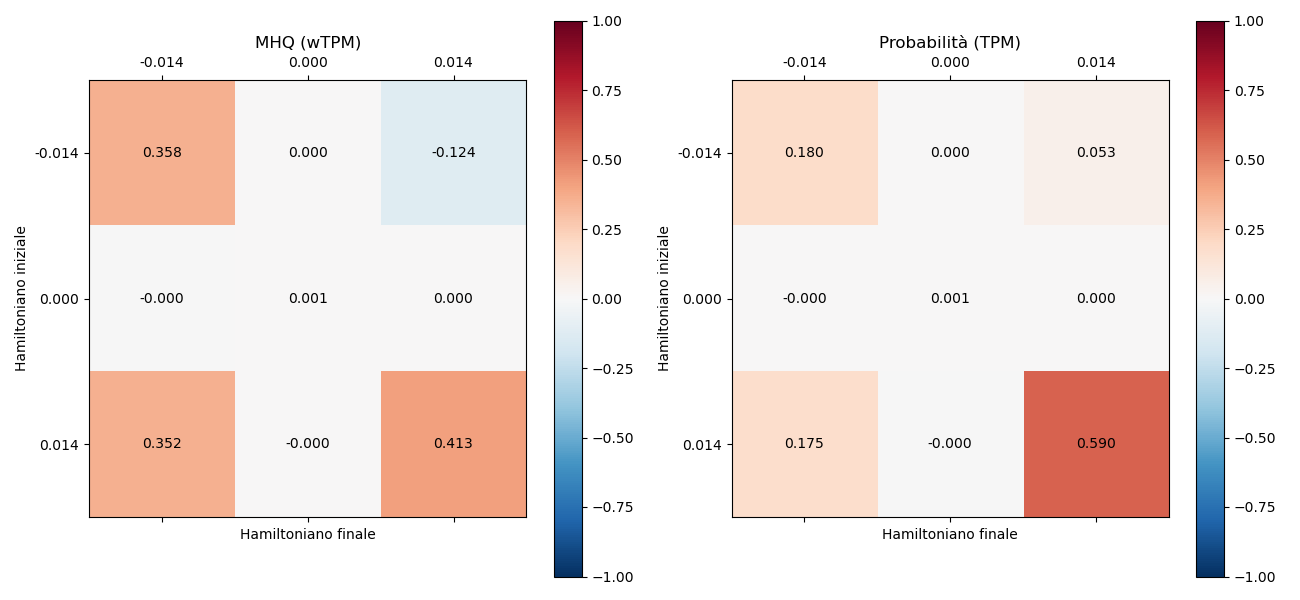

Verifica marginalizzazione:
p_TPM marginals = 0.3552, p_END[0] = 0.7103, Q[:,0] = 0.7103+0.0000j
p_TPM marginals = 0.0009, p_END[1] = 0.0009, Q[:,1] = 0.0009+0.0000j
p_TPM marginals = 0.6439, p_END[2] = 0.2888, Q[:,2] = 0.2888+0.0000j

Somma totale TPM: 1.0000
Somma totale MHQ: 1.0000+0.0000j


In [35]:
%matplotlib widget

# intervallo temporale
t_max = 300
n_steps = 500
t_list = np.linspace(0, t_max, n_steps)


    
# Operatori iniziale e finale
H_iniziale = H_rot(0, args={'phi1': 1.09*Omega1, 'phi2': 1.09*Omega2})                        
H_finale = H_rot(t_list[-1], args={'phi1': 1.09*Omega1, 'phi2': 1.09*Omega2})                  

# Calcolo MHQ
Q, TPM, probabilita_finali = MHQ_3level(rho_xi, H_mw_rot, None, H_iniziale, H_finale, t_list[:-1], args={'phi1': 1.09*Omega1, 'phi2': 1.09*Omega2})
    
# Estrazione autovalori per i labels
autovalori_1, _ = H_iniziale.eigenstates()
autovalori_2, _ = H_finale.eigenstates()
    
autovalori_1 = [np.real(val) for val in autovalori_1]
autovalori_2 = [np.real(val) for val in autovalori_2]
    
# Visualizzazione
plot_MHQ_3level(Q, TPM, autovalori_1, autovalori_2)
    
# Verifica marginalizzazione
print("Verifica marginalizzazione:")
for j in range(3):
    print(f"p_TPM marginals = {TPM[:,j].sum():.4f}, p_END[{j}] = {probabilita_finali[j]:.4f}, Q[:,{j}] = {Q[:,j].sum():.4f}")
    
print(f"\nSomma totale TPM: {TPM.sum():.4f}")
print(f"Somma totale MHQ: {Q.sum():.4f}")

C:\Users\samue\AppData\Local\Temp\ipykernel_15712\579360658.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  Q_evolution[idx] = Q


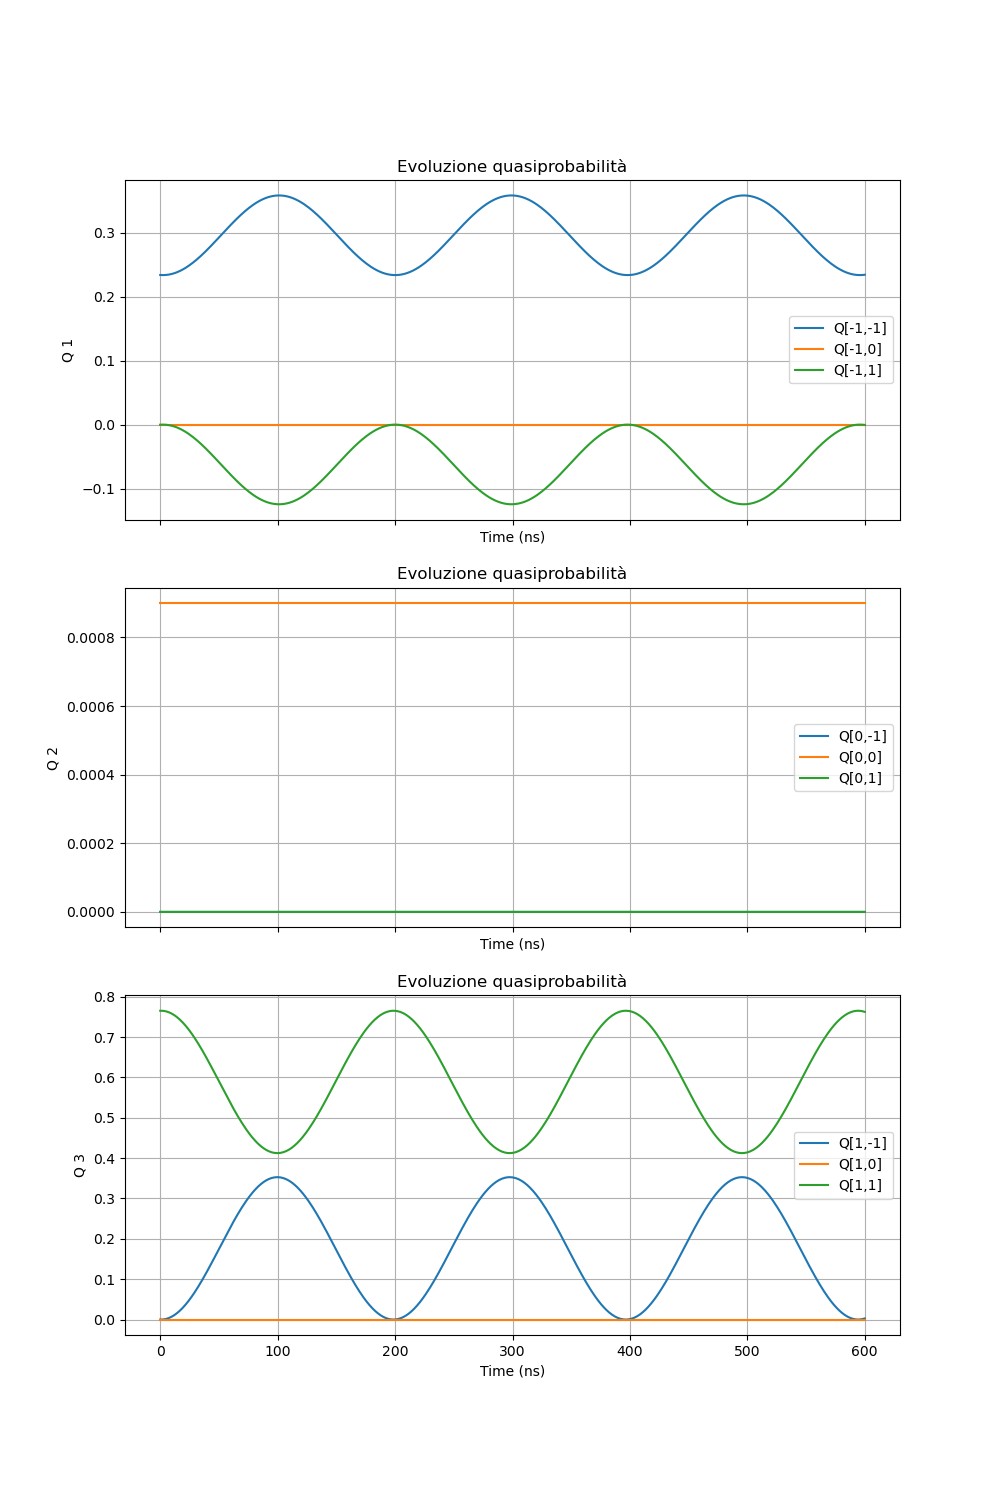

In [37]:
plt.close("all")


# intervallo temporale
t_max = 600
n_steps = 500
t_list = np.linspace(0, t_max, n_steps)

# Inizializzo risultati
Q_evolution = np.zeros((n_steps, 3, 3)) # salvo le diverse matrici Q per ogni t
prob = np.zeros((n_steps, 3))

args = {'phi1': 1.09*Omega1, 'phi2': 1.09*Omega2}

# Calcolo MHQ per ogni t_final
for idx, t_final in enumerate(t_list):
    t_sublist = t_list[:idx+1]  
    Q, TPM, iniziali = MHQ_3level(rho_xi, H_mw_rot, None, H_iniziale, H_rot(t_sublist[-1]), t_sublist, args={'phi1': 1.09*Omega1, 'phi2': 1.09*Omega2}, iniziali= False)  
    Q_evolution[idx] = Q
    prob[idx] = iniziali



fig, ax = plt.subplots(3,1, figsize =(10, 15), sharex=True)
# Plot di Q[i,j](t)
for i in range(3):
    for j in range(3):
        ax[i].plot(t_list, Q_evolution[:, i, j], label=f'Q[{i-1},{j-1}]')
    ax[i].set_xlabel('Time (ns)')
    ax[i].set_ylabel(f'Q {i+1}')
    ax[i].set_title(f'Evoluzione quasiprobabilità')
    ax[i].grid()
    ax[i].legend()

plt.show()

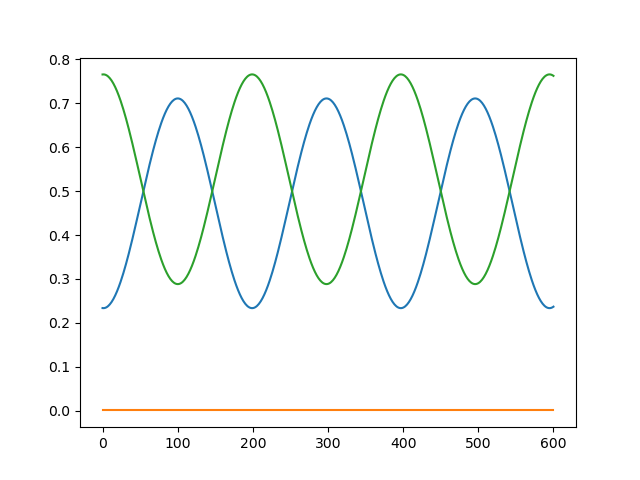

[0.23692213 0.00089991 0.76217796]


In [32]:
plt.close("all")
plt.plot(t_list, prob)
plt.show()

print(prob[-1])

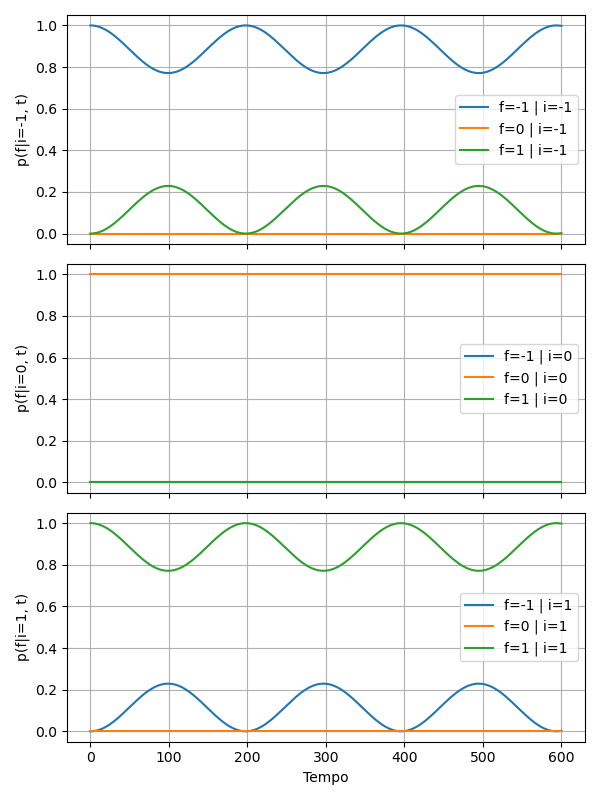

In [33]:
plt.close("all")

def prob_condizionate(initial_state, H, c_ops, O1, H_final_func, t_list, args=None):
    """
    Calcola le probabilità condizionate p(f_j | i, t) dove l'osservabile
    finale è l'Hamiltoniano istantaneo H_final_func(t).
    
    Restituisce:
    TPM_time : ndarray, shape (3, 3, len(t_list))
        TPM_time[i,j,k] = p(f_j | i, t_list[k])
    """
    # Proiettori iniziali
    _, vecs1 = O1.eigenstates()
    projs1 = [v * v.dag() for v in vecs1]
    
    # Preallocazione
    n = len(projs1)
    TPM_time = np.zeros((n, n, len(t_list)))
    
    # Ciclo su esiti iniziali
    for i, P_i in enumerate(projs1):
        rho_i = (P_i * initial_state * P_i).unit()
        result = mesolve(H, rho_i, t_list, c_ops=c_ops, args=args)
        
        # Per ogni tempo, diagonalizzo H_final e calcolo p(f|i,t)
        for idx, t in enumerate(t_list):
            rho_t = result.states[idx]
            Hf = H_final_func(t)
            _, vecs2 = Hf.eigenstates()
            projs2 = [v * v.dag() for v in vecs2]
            for j, P_f in enumerate(projs2):
                TPM_time[i, j, idx] = np.real_if_close((P_f * rho_t).tr())
    
    return TPM_time


# Plotting
def plot_prob_cond(TPM_time, t_list):
    fig, axes = plt.subplots(3, 1, figsize=(6, 8), sharex=True)
    for i in range(TPM_time.shape[0]):
        for j in range(TPM_time.shape[1]):
            axes[i].plot(t_list, TPM_time[i, j, :], label=f"f={j-1} | i={i-1}")
        axes[i].set_ylabel(f"p(f|i={i-1}, t)")
        axes[i].legend()
        axes[i].grid(True)
    axes[-1].set_xlabel("Tempo")
    plt.tight_layout()
    plt.show()


# Calcolo
t_max = 600
n_steps = 500
t_list = np.linspace(0, t_max, n_steps)

TPM_time_inst = prob_condizionate(
    rho_xi,
    H_mw_rot,
    c_ops=[],
    O1=H_iniziale,
    H_final_func=lambda t: H_rot(t),
    t_list=t_list,
    args={'phi1':1.09*Omega1, 'phi2':1.09*Omega2}
)



# Eseguire il plot
plot_prob_cond(TPM_time_inst, t_list)